In [3]:
import sys
sys.path.append('..')
import shapSD as ssd
import pandas as pd
#Display all content in dataframe
pd.set_option('display.max_colwidth', -1)

### Load adult dataset, label encoding dataset

In [4]:
file_path = '../data/adult.csv'
original_adult = pd.read_csv(file_path, index_col=0)

# label encoding dataset
dummy_adult = ssd.DataEncoder(original_adult).onehot_encoding()
dummy_adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,work-class_ Federal-gov,work-class_ Local-gov,work-class_ Never-worked,work-class_ Private,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Show Feature Importance on dataset

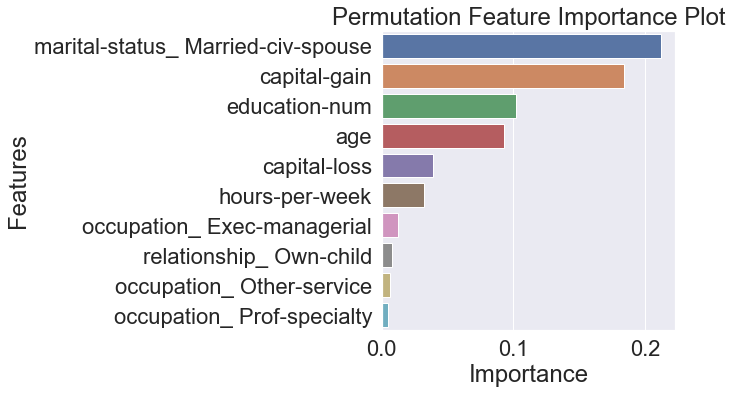

In [6]:
target_col = dummy_adult.columns[-1]
x_train, y_train = dummy_adult.drop(target_col, axis=1), dummy_adult[[target_col]]
# init lightgbm model
dummy_lgb_model = ssd.InitializeModel(x_train, y_train).lgb_clf_model()
# construct FeamtureImportance class, to visualize feature importance
dummy_feature_imp = ssd.FeatureImportance(x_train, y_train, dummy_lgb_model)
dummy_imp = dummy_feature_imp.permutation_importance()[:10]
dummy_feature_imp.vis_perm_importance(dummy_imp)

### Calculate Shapley values

In [7]:
tree_shap = ssd.ShapValues(x_train, dummy_lgb_model, explainer_type='Tree')

Saving figure summary_plot_1563469883


I0718 19:11:32.792095 4590867904 logging_custom.py:46] shap_summary_plot running time: 0M:17s:800ms


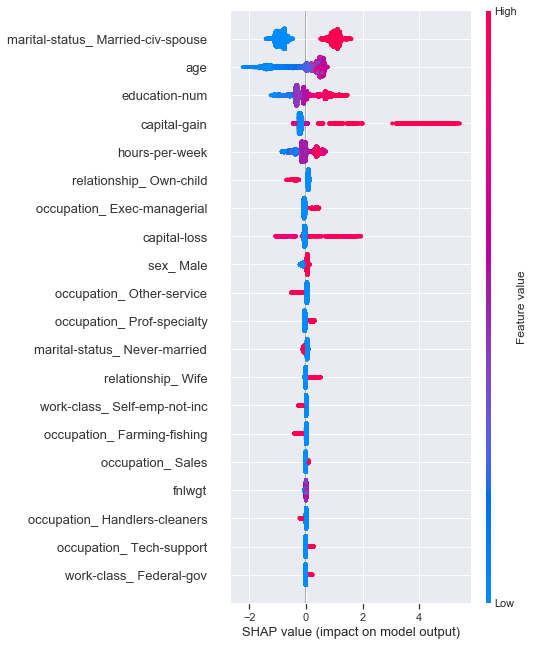

In [8]:
# show shap summary plot
tree_shap.shap_summary_plot()

Saving figure dependence_plot_education-num_1563469907


I0718 19:11:48.303780 4590867904 logging_custom.py:46] shap_dependence_plot running time: 0M:6s:573ms


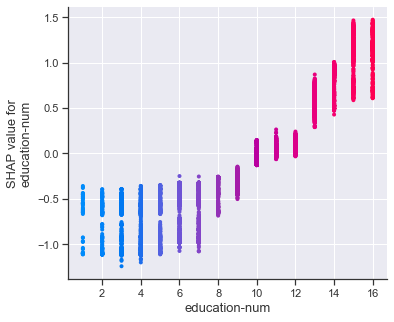

In [9]:
attr = 'education-num'
tree_shap.shap_dependence_plot(ind=attr, interaction_index=attr)

### Exp1: Binary variable flip, target is "prediction change" after flipping

In [11]:
# construct BinaryFlip class
flip_attr = [i for i in x_train.columns if 'sex' in i][0]
b_flip = ssd.BinaryFlip(x_train, y_train, dummy_lgb_model, flip_attr)

In [18]:
# effect from "male" to "female"
df_male = b_flip.calc_flip_effect()
df_male_effect = original_adult.copy()
target_name = df_male.columns[-1]
df_male_effect[target_name] = df_male[target_name]
# df_male_effect = pd.concat([df_male_effect, df_male[[target_name]]], axis=1)
df_male_effect.head()

sex_ Male effect from "1" to "0"


,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,sex_ Male_effect
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0.023124
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0.019467
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0.008187
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0.021988
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0.000000


In [14]:
def subgroup_discovery(df_effect, flip_attr, target_name, measure):
    target = ssd.NumericTarget(target_name)
    search_space = ssd.create_selectors(df_effect, ignore=[flip_attr, target_name, 'income'])
    task = ssd.SubgroupDiscoveryTask(df_effect, target, search_space, qf=measure, result_set_size=10)
    result = ssd.BeamSearch().execute(task)
#     result = spd.overlap_filter(result, df_effect, similarity_level=0.85)
    df_result = ssd.as_df(df_effect, result, statistics_to_show=ssd.all_statistics_numeric)
    return df_result[['quality', 'subgroup', 'size_sg', 'mean_sg', 'mean_dataset', 'mean_lift']]

**Standard Numeric Measure**

In [20]:
df_std_num = subgroup_discovery(df_male_effect, 'sex', target_name, ssd.StandardQFNumeric(1))
df_std_num

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,132.182275,relationship= Husband AND capital-gain: [0:114[,11595.0,0.027479,0.016079,1.709002
1,132.117140,relationship= Husband AND capital-gain: [0:114[ AND marital-status= Married-civ-spouse,11587.0,0.027481,0.016079,1.709142
2,131.271122,relationship= Husband AND capital-gain: [0:114[ AND capital-loss: [0:155[,10739.0,0.028303,0.016079,1.760240
3,124.252901,relationship= Husband,13193.0,0.025497,0.016079,1.585744
4,124.201685,relationship= Husband AND marital-status= Married-civ-spouse,13184.0,0.025499,0.016079,1.585903
5,123.341748,relationship= Husband AND capital-loss: [0:155[,12337.0,0.026077,0.016079,1.621793
6,123.290532,marital-status= Married-civ-spouse AND capital-loss: [0:155[ AND relationship= Husband,12328.0,0.026080,0.016079,1.621988
7,122.210371,relationship= Husband AND native-country= United-States AND capital-gain: [0:114[,10408.0,0.027821,0.016079,1.730274
8,118.921638,relationship= Husband AND race= White AND capital-gain: [0:114[,10473.0,0.027434,0.016079,1.706212
9,117.624905,marital-status= Married-civ-spouse AND capital-loss: [0:155[ AND capital-gain: [0:114[,12199.0,0.025721,0.016079,1.599681


**Incremental Numeric Measure**

In [11]:
df_inc_num = subgroup_discovery(df_male_effect, 'sex', target_name, ssd.IncrementalQFNumeric(1))
df_inc_num

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.013467,relationship= Husband AND capital-gain: [0:114[,11595.0,0.045487,0.02292,1.984586
1,0.012667,relationship= Husband AND capital-loss: [0:155[,12337.0,0.043499,0.02292,1.897846
2,0.012077,relationship= Husband AND marital-status= Married-civ-spouse,13184.0,0.041900,0.02292,1.828056
3,0.012069,relationship= Husband,13193.0,0.041881,0.02292,1.827259
4,0.011900,relationship= Husband AND native-country= United-States,11861.0,0.042637,0.02292,1.860225
5,0.011770,relationship= Husband AND race= White,11940.0,0.042357,0.02292,1.848000
6,0.011417,age: [41:50[ AND relationship= Husband,3384.0,0.058336,0.02292,2.545174
7,0.011255,marital-status= Married-civ-spouse AND capital-gain: [0:114[,13157.0,0.040626,0.02292,1.772505
8,0.010806,relationship= Husband AND work-class= Private,8572.0,0.043981,0.02292,1.918862
9,0.010427,marital-status= Married-civ-spouse AND capital-loss: [0:155[,14018.0,0.038811,0.02292,1.693314


**Decision Tree visulization**

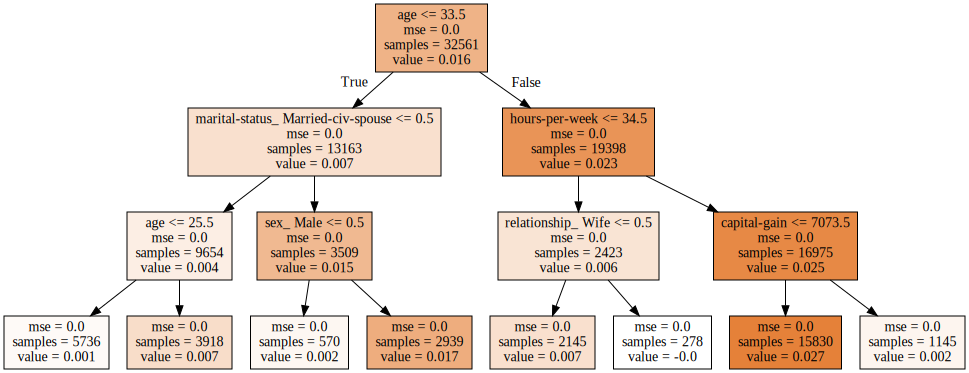

In [22]:
dtree_exp = ssd.DecisionTreeExplain(x_train, df_male[target_name])
estimator = dtree_exp.dtree_reg_model(max_depth=3)
dtree_exp.visualize_dtree(estimator, 'test')

### Exp2: Numeric variable pertubation

**Age Pertubation**

In [26]:
perturb_attr = 'age'
n_perturb = ssd.NumericPerturb(x_train, y_train, dummy_lgb_model, perturb_attr)
# effect of perturb "age" value
df_perturb = n_perturb.calc_perturb_effect()
df_perturb.head()
ignore_attr = list(df_perturb.columns[-2:])
df_perturb_effect = pd.concat([original_adult, df_perturb[ignore_attr]], axis=1)
df_perturb_effect.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_change,age_prediction_change
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,14,0.065649
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,2,0.000000
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,7,0.006957
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,24,0.031196
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,18,0.118090


In [27]:
# age change and prediction change as the complext target
target = ssd.ComplexTarget((ignore_attr[0], ignore_attr[1]))
search_space = ssd.create_selectors(df_perturb_effect, ignore=[ignore_attr[0], ignore_attr[1], 'income', 'age'])
task = ssd.SubgroupDiscoveryTask(df_perturb_effect, target, search_space, qf=ssd.CorrelationQF('entropy'), result_set_size=10)
result = ssd.BeamSearch().execute(task)
# result = ssd.overlap_filter(result, df_perturb_effect, similarity_level=0.85)
df_result_age = ssd.as_df(df_perturb_effect, result, statistics_to_show=ssd.complex_statistics, complex_target=True)
df_result_age

,quality,subgroup,sg_size,dataset_size,complement_sg_size,sg_corr,dataset_corr,complement_sg_corr,corr_lift
0,0.1372,marital-status= Married-civ-spouse AND hours-per-week: [40:41[ AND capital-loss: [0:155[,6694.0,32561.0,25867.0,0.456244,0.269025,0.269011,1.695915
1,0.1359,marital-status= Married-civ-spouse AND hours-per-week: [40:41[,7095.0,32561.0,25466.0,0.448712,0.269025,0.269011,1.667920
2,0.1344,relationship= Husband AND capital-loss: [0:155[ AND hours-per-week: [40:41[,5913.0,32561.0,26648.0,0.465683,0.269025,0.269011,1.731003
3,0.1343,marital-status= Married-civ-spouse AND hours-per-week: [40:41[ AND sex= Male,6347.0,32561.0,26214.0,0.457765,0.269025,0.269011,1.701569
4,0.1341,marital-status= Married-civ-spouse AND capital-gain: [0:114[ AND hours-per-week: [40:41[,6338.0,32561.0,26223.0,0.457525,0.269025,0.269011,1.700676
5,0.1340,marital-status= Married-civ-spouse AND hours-per-week: [40:41[ AND relationship= Husband,6273.0,32561.0,26288.0,0.458537,0.269025,0.269011,1.704438
6,0.1337,relationship= Husband AND sex= Male AND hours-per-week: [40:41[,6274.0,32561.0,26287.0,0.458043,0.269025,0.269011,1.702602
7,0.1337,relationship= Husband AND hours-per-week: [40:41[,6275.0,32561.0,26286.0,0.458131,0.269025,0.269011,1.702929
8,0.1330,relationship= Husband AND work-class= Private AND marital-status= Married-civ-spouse,8566.0,32561.0,23995.0,0.429006,0.269025,0.269011,1.594668
9,0.1329,marital-status= Married-civ-spouse AND work-class= Private,9732.0,32561.0,22829.0,0.420101,0.269025,0.269011,1.561570


**Age increment by 10**

In [28]:
target_name = '{}_prediction_change'.format(perturb_attr)
df_age_increment = n_perturb.calc_add_effect()
df_age_increment = pd.concat([original_adult, df_age_increment[target_name]], axis=1)
df_age_increment.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_prediction_change
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0.010810
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,-0.012401
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0.006957
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,-0.015261
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0.116442


In [11]:
df_age_effect = subgroup_discovery(df_age_increment, perturb_attr, target_name, ssd.IncrementalQFNumeric(1))
df_age_effect

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.008959,education-num>=13 AND marital-status= Never-married,2365.0,0.056684,0.023443,2.417999
1,0.008489,work-class= Private AND marital-status= Married-civ-spouse,9732.0,0.038970,0.023443,1.662352
2,0.008157,marital-status= Married-civ-spouse AND education= Some-college AND work-class= Private,1858.0,0.057639,0.023443,2.458718
3,0.008157,work-class= Private AND marital-status= Married-civ-spouse AND education-num: [10:11[,1858.0,0.057639,0.023443,2.458718
4,0.007886,hours-per-week>=48 AND marital-status= Never-married AND education-num>=13,545.0,0.084394,0.023443,3.600056
5,0.007867,education-num>=13 AND marital-status= Never-married AND sex= Male,1208.0,0.067691,0.023443,2.887529
6,0.007834,work-class= Private AND relationship= Husband,8572.0,0.038711,0.023443,1.651322
7,0.007792,relationship= Husband AND education-num: [10:11[ AND work-class= Private,1632.0,0.058248,0.023443,2.484716
8,0.007792,relationship= Husband AND education= Some-college AND work-class= Private,1632.0,0.058248,0.023443,2.484716
9,0.007558,education= Bachelors AND marital-status= Never-married,1795.0,0.055634,0.023443,2.373226


**Shapley values on 'Age'**

In [30]:
df_age_shap = n_perturb.calc_perturb_shap_values()
shap_col = df_age_shap.columns[-1]
df_age_shap = pd.concat([original_adult, df_age_shap[[shap_col]]],axis=1)
df_age_shap.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_shap_values
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0.507434
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0.503433
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0.348791
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0.493791
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,-0.125857


In [31]:
df_age_shap_effect = subgroup_discovery(df_age_shap, perturb_attr, 'age_shap_values', ssd.IncrementalQFNumeric(1))
df_age_shap_effect

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.195349,relationship= Husband AND marital-status= Married-civ-spouse,13184.0,0.334944,0.027945,11.985750
1,0.195285,relationship= Husband AND sex= Male,13192.0,0.334751,0.027945,11.978821
2,0.195285,relationship= Husband,13193.0,0.334739,0.027945,11.978394
3,0.193968,marital-status= Married-civ-spouse,14976.0,0.313954,0.027945,11.234647
4,0.192715,marital-status= Married-civ-spouse AND sex= Male,13319.0,0.329266,0.027945,11.782561
5,0.186886,relationship= Husband AND native-country= United-States,11861.0,0.337591,0.027945,12.080472
6,0.186190,relationship= Husband AND race= White,11940.0,0.335415,0.027945,12.002590
7,0.186115,marital-status= Married-civ-spouse AND native-country= United-States,13368.0,0.318413,0.027945,11.394188
8,0.185290,marital-status= Married-civ-spouse AND race= White,13410.0,0.316671,0.027945,11.331858
9,0.184838,relationship= Husband AND capital-loss: [0:155[,12337.0,0.328232,0.027945,11.745547
